## Credit Card Fraud Detection 데이터 세트 소개  
전체의 약 0.172%만 사기(=1). 불균형 데이터
![CreditCard](img/CreditCard.png)

## Credit Card Fault Detection ML 모델 구축

이번엔 feature 엔지니어링을 다양하게 해볼 것. 사실 이걸 하려면 한도 끝도 없다.  
굉장히 많은 방식을 통해 데이터를 피쳐 엔지니어링을 하는데   
이번엔 중요 Feature의 데이터 분포도 변경을 하고  
Log 변환을 한다.  
이상치(Outlier)를 제거한다.(굉장히 피쳐 엔지니어링에서 강조되는 것.)  
샘플링. 언더 샘플링과 오버 샘플링이 있는데 언더 샘플링은 사기 데이터만큼 감소시키는 것이고 오버 샘플링은 뻥튀기 시키는 것.대표적인 방식으로는 SMOTE가 있는데 간단히 설명할 것.

![CCFaultDetection](img/FaultDetection.png)

## Log 변환

![LogChange](img/LogChange.png)

## IQR(Inter Quantile Rnage)를 이용한 Outlier Removal

IQR 방식으로 Outlier를 detection 할 것. Quatile(4분위)하여 4조각으로 나눌 것.

가장 효과적으로 시각화 할 수 있는 것이 박스 플롯. 박스의 가장 밑바닥이 1/4 분위수. 중간이 2분위. 맨위가 3/4 분위. 여기까지의 범위를 IQR이라 함.  

최소값과 최대 값을 정할 때 **최소 값은 보통 1/4 분위수에서 1.5 * IQR을 하지만 뺀 값. 최대값은 3/4 분위하지만 수에서 1.5 * IQR을 더 한 값.**

![IQR](img/IQR.png)

## 언더 샘플링과 오버 샘플링

![UnderOver](img/UnderOver.png)

## SMOTE(Synthetic Minority Over-Sampling Technique) 개요

오버샘플링 테크닉. 원본 데이터 중 회색이 사기데이터라고 한다면, 사기데이터의 클래스 값들의 가까운 쪽으로 KNN 레이블을 한다.  

그 이웃사이의 공간사이에 랜덤값에서 population을 시키는 것

![SMOTE](img/SMOTE.png)

### 데이터 일차 가공 및 모델 학습/예측/평가

**데이터 로드**

In [19]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


첫번째 Time은 큰 의미가 없다. 나중에 drop할 것. 레코드가 만들어지는데 걸린 시간.(즉 데이터 만드는데 걸린 시간)  
V1에서부터 v28까지 속성이 있다. 이걸 보면 feature 이름이 전혀 들어가 있지 않다.  
kaggle에 가서 다시 설명을 읽어보면


V1
may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)  

v1에서부터 v28까지는 민감한 정보를 보호하기 위해 PCA 압축을 통해 나온 것.

Amount는 카드 사용액

Class는 0이 정상 사용 1이 부정 카드 사용

In [20]:
card_df.shape

(284807, 31)

shape을 보니 284807개의 레코드가 있고 31개의 feature와 타겟 컬럼으로 되어 있다.

뭘할거냐면, 이 모델의 특징이 피쳐 엔지니어링을 하겠다는 것임. 데이터들에 대해서 로그변환을 하고,

아웃라이어를 디텍션하고 오버샘플링을하여 두개의 서로 다른 머신러닝 알고리즘에 적용을 할 거임.

**원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사하여 반환**

In [21]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

** 학습과 테스트 데이터 세트를 반환하는 함수 생성. 사전 데이터 처리가 끝난 뒤 해당 함수 호출  **

In [22]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    #stratify 파라미터가 하는게 뭐냐면 타겟값의 분포도에 따라서 학습과 테스트 데이터를 맞춰서 분할을 해줌
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [23]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [25]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)


오차 행렬
[[85279    16]
 [   64    84]]
정확도: 0.9991, 정밀도: 0.8400, 재현율: 0.5676,    F1: 0.6774, AUC:0.9513


재현율이 생각보다 낮게 나왔다. 예측모델로써 그렇게 탐탁치 않다.

**앞으로 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하므로 이를 위한 함수 생성** 

In [26]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    

**LightGBM 학습/예측/평가.**

(boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨.)  
   LightGBM 2.1.0 이상 버전에서 이와 같은 현상 발생 

In [27]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


재현율이 로지스틱 리그레이션보다는 많이 좋아졌다. 그러나 아직 많이 좋아질 수 있는 요소들이 많다.

### 중요 데이터 분포도 변환 후 모델 학습/예측/평가


**중요 feature의 분포도 확인**

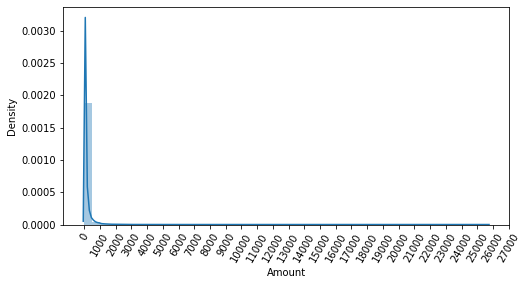

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

롱 테일(쭉 길게 나옴) 구조인걸 확인했다.

**데이터 사전 가공을 위한 별도의 함수에 StandardScaler를 이용하여 Amount 피처 변환**

In [29]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    #fit_transform으로 amount 시리즈 데이터를 변환해서 amount_n으로 새로 만듦.
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

**StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가**

In [30]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


**Amount를 로그 변환**

In [31]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환. 원래는 np.log()인데 np.log1p()썼다. 
    # 왜냐하면 1p라는건 1plus의 약자로 하나를 더하겠다는 의미이다. 왜 이걸 썼는지는 밑에.
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [32]:
# log1p 와 expm1 설명 
import numpy as np

print(1e-1000 == 0.0)

print(np.log(1e-1000)) #이러면 마이너스 무한대가 나온다.함

print(np.log(1e-1000 + 1)) #그래서 1을 더하는 식으로 한다.
print(np.log1p(1e-1000))

True
-inf
0.0
0.0


In [33]:
var_1 = np.log1p(100)
var_2 = np.expm1(var_1)# 다시 원본 값으로 바꿀때는 expm1을 한다. m1은 minus 1. 하나 빼겠다는 뜻.
print(var_1, var_2)

4.61512051684126 100.00000000000003


In [34]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


### 이상치 데이터 제거 후 모델 학습/예측/평가

**각 피처들의 상관 관계를 시각화. 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출**

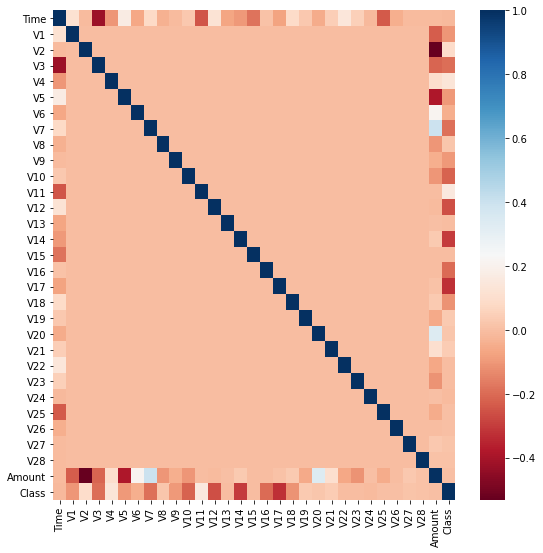

In [36]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()#corr 메소드를 호출하면 각각의 칼럼들간의 상관도를 나타내줌
sns.heatmap(corr, cmap='RdBu')
# 시본의 히트맵의 인자로 넣어주면 시각화 해줌. cmap이라는건 컬러 맵임. 컬러로 상관도 값을 직관적으로 이해할 수 있게 시각적으로 표현해줌
# 짙은 파랑으로 갈 수록 양의 상관관계가 높음. 빨갈수록 음의 상관관계가 높음.
# 대각선으로 다 파랗게 짙은게 당연하다.
# class의 값에 상관관계가 높은걸 찾아보면 v12, v14, v17이 빨갛다. 

위의 class 중의 v14에 해당하는 것만 outlier를 찾아보도록 하자.

**Dataframe에서 outlier에 해당하는 데이터를 필터링하기 위한 함수 생성. outlier 레코드의 index를 반환함.**

In [37]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index
    

In [38]:
#np.percentile(card_df['V14'].values, 100) # 이건 np.max()값이랑 똑같다.
np.max(card_df['V14'])

10.5267660517847

In [39]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


결과, 이상치 데이터 인덱스 4개가 나왔다. 이건 나중에 삭제할 것임.

**로그 변환 후 V14 피처의 이상치 데이터를 삭제한 뒤 모델들을 재 학습/예측/평가**

In [40]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)# row, 즉 행을 삭제할 것이기 떄문에 axis = 0. 컬럼을 삭제하는것은 axis = 1
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


결과, 재현율 상승.

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

#y 타겟값이 반드시 들어와야된다. y 타겟값의 분포도에 따라서 피쳐를 만들어주기 때문에.
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


적용 후 레이블 값 분포를 보니까 둘이 똑같다. 그렇다면 원래는 어떻게 됐는지 알아보자.

In [42]:
y_train.value_counts()

0    199020
1       342
Name: Class, dtype: int64

원래는 1값이 342개 밖에 없었다. 이렇게 증식이 되었다. 이 증식된 데이터를 기반으로 다시 한번 학습/예측/평가를 해보자.

**로지스틱 회귀로 학습/예측/평가**

In [43]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)


오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


보면 재현율은 무척 좋아졌다. 그런데 정밀도가 한없이 나빠져있다. F1 스코어가 이것 때문에 많이 나빠졌다. 

**Precision-Recall 곡선 시각화**

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    


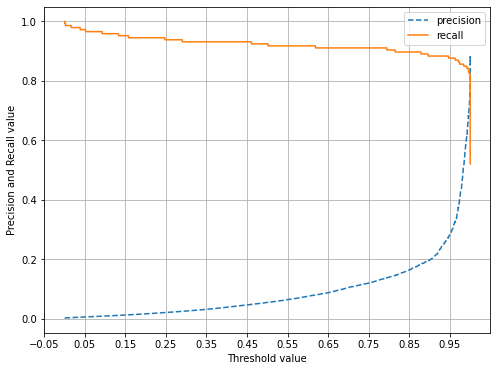

In [45]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

재현율은 좋은데 문제는 정밀도가 무척 낮다. 실전에 적용하기에는 부적합한 모델이 될 것 같다.

**LightGBM 모델 적용**

In [46]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


정밀도는 떨어지고 재현율은 조금 높아졌다.

## 피처 엔지니어링에 따른 신용카드 사기 검출 모델 성능 비교

|데이터 가공 유형|머신러닝 알고리즘|정밀도|재현율|ROC-AUC|
|:--------------:|:---------------:|:----:|:----:|:-----:|
|데이터 가공 없음|로지스틱 회귀    |0.8400|0.5676|0.9513|  
|                |LightGBM         |0.9573|0.7568|0.9790|
|데이터 로그 변환|로지스틱 회귀    |0.8812|0.6014|0.9727|
|                |LightGBM         |0.9576|0.7635|0.9796|
|이상치 데이터 제거|로지스틱 회귀  |0.8750|0.6712|0.9743|
|                |LightGBM         |0.9603|0.8288|0.9780|
|SMOTE 오버 샘플링|로지스틱 회귀   |0.0542|0.9247|0.9737|
|                 |LightGBM        |0.9118|0.8493|0.9814|  

amount 로그변환을 하니 정밀도가 약간 씩 증가했다.  
가장 성능이 많이 좋아진건 이상치 데이터 제거이다. 사기데이터 건수 4건만 지운 것임.  
재현율이 상당히 올라갔다. 실제로도 이상치 데이터제거는 효과가 크다.  
SMOTE 오버 샘플링은 재현율이 많이 증가했으나 정밀도가 너무 많이 떨어졌다.  
SMOTE 의 LightGBM의 경우도 정밀도가 약간 희생되며 재현율이 올랐다.